# Bio-JEPA AC 

Based on [V-JEPA 2 AC](https://arxiv.org/abs/2506.09985)

**Goal**
Our goal is to build a World Model for cell biology. In it's current configuration, our model calculates that hitting a cell with a specific gene knockout, or drug if we had it in the dataset, causes specific biological pathways to activate or shut down. Unlike an LLM, this is a predictive simulation that operates entirely within a compressed mathematical space to understand cause and effect.

The process begins with the inputs, which feed the model three distinct pieces of information for every training step. 
	First, it receives the **Before** state, which is data representing a healthy control cell. Instead of a messy list of 20,000 raw gene counts, the tokenizer has already compressed this into a structured set of pathway scores (using [Reactome Pathway 2024 data](https://maayanlab.cloud/Harmonizome/dataset/Reactome+Pathways+2024)). This essentially tells the model that the cell currently has high energy, low stress, and normal growth. 
	Second, the model receives the **Action**, which is the specific perturbation performed in the lab, in our case a CRISPR knockdown of a specific gene. This could also be a drug application or protein introduction if we had the data. This is converted into a learnable "Action Embedding," effectively serving as the command that tells the simulation what event just occurred. 
	Third, the model is given the **After** state, which is the actual knockdown cell observed in the experiment. This third input serves purely as the target or "ground truth"; the model is not allowed to see it while making its prediction, but uses it afterwards in the loss calculation and backprop.

Inside the model, a three-step simulation plays out to process these inputs. It starts with the **Student Encoder**, or the *Perception* module, which looks at the healthy **Before** cell input  and compresses it into a Latent State. At this stage, the model is simply understanding the baseline biological status of the cell. This latent representation is then passed to the **Action-Conditioned Predictor**, which acts as the *Physics Engine.* This component combines the cell's current state with the Action vector. Using a mechanism called Adaptive Layer Normalization (AdaLN), the action actually modulates the internal weights of the neural network, effectively shifting the physical rules of the simulation to match the drug's effects. The **Predictor** then tries to predict, or hellucinate, what the future state of the cell will be, calculating a new vector that represents the cell's condition after the knockout, or drug impact. 

To validate the predictor, simultaneously the **Teacher Encoder** looks at the real **After** data from the lab and encodes it into that same latent space to serve as the judge. To learn, the model compares the predictor output against the Teacher's reality. With backprop, we attempt to minimize the difference between the prediction and the actual outcome, trying to minimize this error over millions of examples. 

In theory, by forcing its predictions to match reality, the model moves beyond simply memorizing data and begins to learn the underlying causal rules of biology. It figures out gene regulatory logic—understanding that if Gene A is knocked down, Pathway B must functionally fail. It learns how different pathways, like inflammation and cell death, are causally linked. Ultimately, we hope it learns the "physics" of how perturbations work, allowing us to eventually simulate the effects of gene mutations, drugs or genetic interventions on cells without having to perform the physical experiment in a wet lab.

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
import itertools


In [3]:
torch.manual_seed(1337)
random.seed(1337)

In [4]:
!nvidia-smi

Sat Dec 20 19:57:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   47C    P0             97W /  700W |       4MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
torch.cuda.is_available()

True

In [6]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cuda


## Components

### ROTARY POSITIONAL EMBEDDINGS (RoPE)
V-JEPA 2 uses 3D-RoPE. We adapt this to 1D-RoPE for our list of Pathway Tokens.

In [7]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        # Ensure dim is the head dimension, not the full embedding dimension
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_seq_len).type_as(inv_freq)
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        # x: [Batch, Seq, Dim]
        # We only care about the sequence length here
        n = x.shape[1]
        # Returns [Seq, Head_Dim]
        return self.emb[:n, :].cos(), self.emb[:n, :].sin()

def apply_rotary_pos_emb(q, k, cos, sin):
    # q, k: [Batch, Heads, Seq, Head_Dim]
    # cos, sin: [Seq, Head_Dim] -> reshape to [1, 1, Seq, Head_Dim]
    
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)

    # Standard RoPE rotation logic
    # split last dim into half
    q_d = q.shape[-1] // 2
    k_d = k.shape[-1] // 2
    
    q1, q2 = q[..., :q_d], q[..., q_d:]
    k1, k2 = k[..., :k_d], k[..., k_d:]
    
    q_rotated = torch.cat((-q2, q1), dim=-1)
    k_rotated = torch.cat((-k2, k1), dim=-1)
    
    q_out = (q * cos) + (q_rotated * sin)
    k_out = (k * cos) + (k_rotated * sin)
    
    return q_out, k_out

### Multi-Headed Attention

In [8]:
class BioMultiHeadAttention(nn.Module):
    # mirrors nn.MultiheadAttention(dim, heads, batch_first=True) 
    def __init__(self, config):
        super().__init__()
        assert config.embed_dim % config.heads == 0
        
        self.head_dim = config.embed_dim // config.heads
        self.heads = config.heads
        self.embed_dim = config.embed_dim
        
        # Projections
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        
        self.c_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x, cos, sin):
        B, T, C = x.size() # Batch, Seq, Embed Dim
        
        # 1. Project
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # 2. Reshape for multi-head attention
        # (B, T, nh, hs) -> (B, nh, T, hs)
        q = q.view(B, T, self.heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.heads, self.head_dim).transpose(1, 2)

        # 3. Apply RoPE to Q and K (Rotary is applied per head)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # 4. Attention
        # is_causal=False because this is a bidirectional encoder
        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)
        
        # 5. Reassemble
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        
        return y

### MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embed_dim, int(config.mlp_ratio * config.embed_dim))
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(int(config.mlp_ratio * config.embed_dim), config.embed_dim)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

### Hidden Transfomer Block

In [10]:
class PathwayBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = BioMultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.mlp = MLP(config)

    def forward(self, x, cos, sin):
        # 1. Attention with RoPE
        x_norm = self.ln_1(x)
        # Pass cos/sin into attn to be applied to Q/K
        attn_out = self.attn(x_norm, cos, sin)
        x = x + attn_out

        # 2. MLP
        x = x + self.mlp(self.ln_2(x))
        return x

### Pathway Encoder

In [11]:
@dataclass
class PathwayEncoderConfig:
    num_pathways: int = 1024 
    n_layer: int = 24 
    heads: int = 12
    embed_dim: int = 768
    mlp_ratio: float = 4.0 # Changed to float for precision

class PathwayEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # input projects to embedding
            input_proj = nn.Linear(1, config.embed_dim),
            
            # RoPE needs the HEAD dimension, not the full embedding dimension
            rope = RotaryEmbedding(config.embed_dim // config.heads),
            
            # transformer block
            blocks = nn.ModuleList([PathwayBlock(config) for _ in range(config.n_layer)]),
            
            # final layer norm
            ln_f = nn.LayerNorm(config.embed_dim) 
        ))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
        
    def forward(self, x):
        # x: [Batch, Num_Pathways]
        x = x.unsqueeze(-1) # [B, N, 1]
        x = self.transformer.input_proj(x) # [B, N, Dim]
        
        # Generate RoPE cache
        # cos, sin are [Seq, Head_Dim]
        cos, sin = self.transformer.rope(x)
        cos, sin = cos.to(x.device), sin.to(x.device)
        
        for block in self.transformer.blocks:
            x = block(x, cos, sin)
            
        x = self.transformer.ln_f(x)

        return x

### Adaptive Layer Normalization AdaLN

In [12]:
class AdaLN(nn.Module):
    '''
    Adaptive Layer Norm for conditioning the predictor on action embeddings.
    The action vector regresses the Scale (gamma) and Shift (beta) of the normalization.
    '''
    def __init__(self, embed_dim, action_embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
        self.action_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(action_embed_dim, 2 * embed_dim)
        )
        # Initialize to identity (gamma=0, beta=0 originally, effectively gamma=1 after logic)
        # Zero-init the last layer so the action starts as a "no-op" (identity)
        nn.init.zeros_(self.action_mlp[1].weight)
        nn.init.zeros_(self.action_mlp[1].bias)

    def forward(self, x, action_emb):
        # x: [Batch, Seq, Dim]
        # action_emb: [Batch, action_embed_dim]
        
        # Project action to style: [B, 2*D] -> [B, 1, 2*D]
        style = self.action_mlp(action_emb).unsqueeze(1) 
        gamma, beta = style.chunk(2, dim=-1)
        
        # Apply affine transformation based on action
        return self.norm(x) * (1 + gamma) + beta

### Predictor Block

In [13]:
class PredictorBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 1. Conditioning (AdaLN) replaces standard LayerNorm
        self.ada_ln1 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 2. Attention (Using the shared BioMultiHeadAttention)
        self.attn = BioMultiHeadAttention(config)
        
        # 3. Conditioning (AdaLN) for the MLP block
        self.ada_ln2 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 4. MLP (Using the shared MLP)
        self.mlp = MLP(config)

    def forward(self, x, action_emb, cos, sin):
        # 1. AdaLN -> Attention (with internal RoPE) -> Residual
        x_norm = self.ada_ln1(x, action_emb)
        
        # Note: BioMultiHeadAttention handles q/k/v projection and apply_rotary_pos_emb internally
        attn_out = self.attn(x_norm, cos, sin)
        x = x + attn_out
        
        # 2. AdaLN -> MLP -> Residual
        x_norm = self.ada_ln2(x, action_emb)
        x = x + self.mlp(x_norm)
        
        return x

### Main Predictor Model

In [14]:
@dataclass
class ACPredictorConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 384
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power

class ACPredictor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Action Embedding (Discrete ID -> Vector)
        self.action_embed = nn.Embedding(config.max_perturb, config.action_embed_dim)
        
        # Learnable Queries ("Mask Tokens") for the future state
        # One query vector per pathway position
        self.mask_queries = nn.Parameter(torch.randn(1, config.num_pathways, config.embed_dim) * 0.02)
        
        # RoPE: initialized with HEAD dimension (dim // heads)
        head_dim = config.embed_dim // config.heads
        self.rope = RotaryEmbedding(head_dim)
        
        self.blocks = nn.ModuleList([
            PredictorBlock(config) for _ in range(config.n_layer)
        ])
        
        self.final_norm = AdaLN(config.embed_dim, config.action_embed_dim)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, context_latents, action_ids):
        """
        context_latents: [Batch, N, Dim] (From Student Encoder)
        action_ids: [Batch] (Ints)
        """
        B, N, D = context_latents.shape
        
        # 1. Embed Action
        action_emb = self.action_embed(action_ids) # [B, action_embed_dim]
        
        # 2. Construct Input: [Context, Mask_Queries]
        # We concatenate the learned queries to the context. 
        # The predictor will attend to the context to update the queries.
        queries = self.mask_queries.repeat(B, 1, 1) # [B, N, D]
        sequence = torch.cat([context_latents, queries], dim=1) # [B, 2N, D]
        
        # 3. Generate RoPE for the full sequence (2N)
        # cos, sin are [2N, Head_Dim]
        cos, sin = self.rope(sequence)
        cos, sin = cos.to(sequence.device), sin.to(sequence.device)
        
        # 4. Pass through AdaLN Blocks
        for block in self.blocks:
            sequence = block(sequence, action_emb, cos, sin)
            
        sequence = self.final_norm(sequence, action_emb)
        
        # 5. Return only the predicted part (The Queries corresponding to N..2N)
        predictions = sequence[:, N:, :] 
        return predictions

## Bio-JEPA AC

In [15]:
@dataclass
class BioJepaConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 256
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power
    
class BioJepa(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.student = PathwayEncoder(PathwayEncoderConfig(
            num_pathways = config.num_pathways,
            n_layer= config.n_layer, 
            heads=config.heads, 
            embed_dim= config.embed_dim
        ))
                                      
        self.teacher = copy.deepcopy(self.student)
        
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False
            
        self.predictor = ACPredictor(ACPredictorConfig(
            n_layer=config.n_layer, 
            heads=config.heads, 
            embed_dim=config.embed_dim, 
            action_embed_dim=config.action_embed_dim,
            num_pathways=config.num_pathways
        ))
        
    def forward(self, x_control, x_treated, action_id):
        # 1. Teacher
        with torch.no_grad():
            target_latents = self.teacher(x_treated)
            
        # 2. Student 
        context_latents = self.student(x_control)
        
        # 3. Predictor 
        predicted_latents = self.predictor(context_latents, action_id)
        
        # 4. Latent Loss (L1)
        loss = F.l1_loss(predicted_latents, target_latents)
        
        return loss

    @torch.no_grad()
    def update_teacher(self, m=0.996):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data.mul_(m).add_((1 - m) * param_s.data)

## Training

#### Prep

In [16]:
data_dir = Path('/home/ubuntu/data/jepa')
shard_dir = data_dir / 'tokenized'
train_dir = shard_dir / 'train'
val_dir =  shard_dir / 'val'
metadata_path = data_dir / 'perturbation_map.json'
checkpoint_dir = data_dir / 'checkpoint'

In [43]:
BATCH_SIZE = 256
n_embd = 128
n_pathways = 1024
LR = 3e-4
EPOCHS = 15
tok_file_chunk_size = 10000

**Favor Iterable**

In [18]:
class PairedShardIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, shard_dir, shuffle_buffer_size=1000):
        self.files = sorted(shard_dir.glob('*.npz'))
        self.shuffle_buffer_size = shuffle_buffer_size
        print(f'Found {len(self.files)} shards.')

    def _parse_shard(self, file_path):
        with np.load(file_path) as data:
            # Load fully into memory (assuming shards fit in RAM given "plenty of memory")
            controls = data['control']
            cases = data['case']
            ids = data['action_ids']
            
            # Shuffle indices within the shard for local randomness
            indices = np.random.permutation(len(ids))
            
            for idx in indices:
                yield controls[idx], cases[idx], ids[idx]


    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        
        # Shard distribution logic for multi-worker support
        if worker_info is None:
            # Single process
            file_iter = self.files
        else:
            # Split files among workers
            worker_id = worker_info.id
            num_workers = worker_info.num_workers
            file_iter = self.files[worker_id::num_workers]

        # Shuffle file order so workers don't process same files in same order (if unlucky)
        random.shuffle(file_iter)
        
        # Generator that yields items from shards
        iterator = (item for f in file_iter for item in self._parse_shard(f))
        
        # Buffer for inter-shard shuffling
        buffer = []
        for item in iterator:
            buffer.append(item)
            if len(buffer) >= self.shuffle_buffer_size:
                # Yield random item from buffer
                idx = random.randint(0, len(buffer) - 1)
                yield self._process_item(buffer.pop(idx))
        
        # Clear remaining buffer
        random.shuffle(buffer)
        for item in buffer:
            yield self._process_item(item)

    def _process_item(self, item):
        c, t, a = item
        # Convert to tensor here
        return (torch.tensor(c), torch.tensor(t), torch.tensor(a, dtype=torch.long))

#### Data Loader

In [44]:
# train_dataset = PairedShardDataset(train_dir)
# val_dataset = PairedShardDataset(val_dir)
train_dataset = PairedShardIterableDataset(train_dir)
val_dataset = PairedShardIterableDataset(val_dir)

Found 29 shards.
Found 1 shards.


In [45]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    #num_workers=8,  
    pin_memory=True 
)
cycle_train_loader = itertools.cycle(train_loader)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    #num_workers=8,  
    pin_memory=True 
)
cycle_val_loader = itertools.cycle(val_loader)

#### Training

In [21]:
torch.set_float32_matmul_precision('high')

In [22]:
model = BioJepa(BioJepaConfig(
    num_pathways=n_pathways,
    embed_dim = n_embd
)).to(DEVICE)

#model = torch.compile(model)

#### Optimizer

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

#### Scheduler

In [46]:
steps_per_epoch = 299694 // BATCH_SIZE
max_steps = EPOCHS * steps_per_epoch
steps_per_epoch, max_steps

(1170, 17550)

In [48]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=max_steps, pct_start=0.05
)

#### Training Loop

In [26]:
lossi = []
step = 0
total_epoch_loss = 0

In [50]:
for step in range(max_steps):
    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 250 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            test_loss_accum = 0.0
            test_loss_steps = 5
            for i in range(test_loss_steps):
                xc, xt, aid = next(cycle_val_loader)
                xc, xt, aid = xc.to(DEVICE), xt.to(DEVICE), aid.to(DEVICE)
                loss = model(xc, xt, aid)
                loss = loss / test_loss_steps
                test_loss_accum += loss.detach()

        print(f'test loss: {test_loss_accum.item():.4f}')
        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')


    if step > 0 and (step % 1000 == 0 or step % steps_per_epoch ==0) and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    model.train()
    xc, xt, aid = next(cycle_train_loader)
    xc, xt, aid = xc.to(DEVICE), xt.to(DEVICE), aid.to(DEVICE)
    
    optimizer.zero_grad()
    
    loss = model(xc, xt, aid)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher(m=0.996)
    
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    step += 1
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')

            

test loss: 0.3809
Step 25 | Loss: 0.37349 | LR: 1.26e-05
Step 50 | Loss: 0.36728 | LR: 1.43e-05
Step 75 | Loss: 0.38177 | LR: 1.72e-05
Step 100 | Loss: 0.37183 | LR: 2.12e-05
Step 125 | Loss: 0.37828 | LR: 2.62e-05
Step 150 | Loss: 0.37911 | LR: 3.23e-05
Step 175 | Loss: 0.37762 | LR: 3.94e-05
Step 200 | Loss: 0.37565 | LR: 4.74e-05
Step 225 | Loss: 0.36258 | LR: 5.63e-05
Step 250 | Loss: 0.38623 | LR: 6.60e-05
test loss: 0.3667
Step 275 | Loss: 0.39090 | LR: 7.65e-05
Step 300 | Loss: 0.37920 | LR: 8.75e-05
Step 325 | Loss: 0.39475 | LR: 9.91e-05
Step 350 | Loss: 0.37844 | LR: 1.11e-04
Step 375 | Loss: 0.38494 | LR: 1.24e-04
Step 400 | Loss: 0.39875 | LR: 1.36e-04
Step 425 | Loss: 0.41487 | LR: 1.49e-04
Step 450 | Loss: 0.38478 | LR: 1.62e-04
Step 475 | Loss: 0.37579 | LR: 1.75e-04
Step 500 | Loss: 0.38416 | LR: 1.88e-04
test loss: 0.3660
Step 525 | Loss: 0.39097 | LR: 2.00e-04
Step 550 | Loss: 0.39495 | LR: 2.12e-04
Step 575 | Loss: 0.35840 | LR: 2.24e-04
Step 600 | Loss: 0.34752 | LR

#### Training Loss Plot

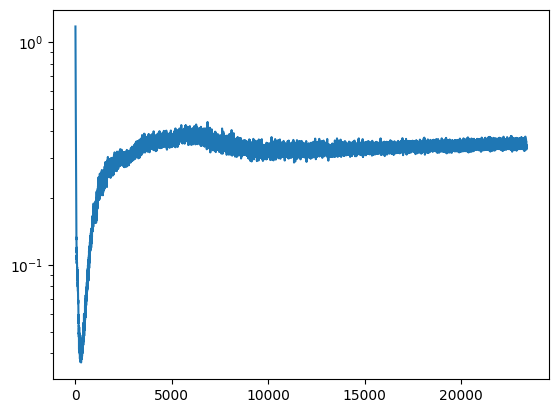

In [52]:
plt.plot(lossi)
plt.yscale('log')

## Test Inference

In [53]:
metadata_path, val_dir

(PosixPath('/home/ubuntu/data/jepa/perturbation_map.json'),
 PosixPath('/home/ubuntu/data/jepa/tokenized/val'))

In [54]:
# 1. Load Map (ID -> Name)
with open(metadata_path, "r") as f:
    pert_map = json.load(f)
# Invert map to: ID -> Name
id_to_name = {v: k for k, v in pert_map.items()}

In [55]:
model.eval()

BioJepa(
  (student): PathwayEncoder(
    (transformer): ModuleDict(
      (input_proj): Linear(in_features=1, out_features=128, bias=True)
      (rope): RotaryEmbedding()
      (blocks): ModuleList(
        (0-5): 6 x PathwayBlock(
          (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): BioMultiHeadAttention(
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (c_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=128, out_features=512, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=512, out_features=128, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((

**Get random data sample**

In [56]:
def get_random_test_pair(shard_dir):
    '''Grab a single real pair from a random shard'''
    files = sorted(shard_dir.glob('*.npz'))
    file_path = files[np.random.randint(len(files))]
    
    with np.load(file_path) as data:
        idx = np.random.randint(data['action_ids'].shape[0])
        
        # Extract raw uint32
        control_raw = data['control'][idx]
        case_raw = data['case'][idx]
        act_id = data['action_ids'][idx]
        
    # Dequantize
    x_control = torch.tensor(control_raw.astype(np.float32)).unsqueeze(0).to(DEVICE) # [1, 1024]
    x_case = torch.tensor(case_raw.astype(np.float32)).unsqueeze(0).to(DEVICE)
    action_id = torch.tensor([act_id], dtype=torch.long).to(DEVICE)
    
    return x_control, x_case, action_id

In [57]:
x_control, x_case, action_id = get_random_test_pair(val_dir)
pert_name = id_to_name[action_id.item()]
pert_name

'ELP2'

In [58]:
# 2. Get Baselines (Teacher View)
# We need the Teacher to tell us where the "Control" and "Real Treated" 
# sit in the abstract latent space.
with torch.no_grad():
    z_control = model.teacher(x_control)       # Where the cell started
    z_case = model.teacher(x_case)     # Where the cell actually went

In [59]:
# 3. Run The Physics Engine (Predictor)
# Student encodes context -> Predictor adds Action -> Output
with torch.no_grad():
    z_context = model.student(x_control)
    z_predicted = model.predictor(z_context, action_id) # Where the model thinks it went

**Analysis**

In [60]:
# Metric 1: Baseline Drift (How much did the drug actually change the cell?)
# If this is 0, the drug did nothing, so prediction is trivial.
drift = F.l1_loss(z_control, z_case).item()
drift

0.370823472738266

In [61]:
# Metric 2: Prediction Error (How close is our guess to the real result?)
error = F.l1_loss(z_predicted, z_case).item()
error

0.24255585670471191

In [62]:
# Metric 3: Simulation Magnitude (How much did our model decide to move the cell?)
sim_move = F.l1_loss(z_control,z_predicted).item()
sim_move

0.2586187422275543

In [63]:
# --- INTERPRETATION ---
print(f"[Result Interpretation]")
if drift < 0.01:
    print(f"⚠️  WEAK SIGNAL: This perturbation didn't change the cell much in reality.")
elif error < drift:
    improvement = (1 - (error / drift)) * 100
    print(f"✅ SUCCESS: The model predicted the state shift!")
    print(f"   The prediction is {improvement:.1f}% closer to the truth than the Control state was.")
else:
    print(f"❌ FAILURE: The model failed to capture the dynamics.")
    print(f"   It would have been better to just guess 'Nothing Happened'.")

[Result Interpretation]
✅ SUCCESS: The model predicted the state shift!
   The prediction is 34.6% closer to the truth than the Control state was.


In [64]:
# Which latent dimensions changed the most?
# This gives us a "fingerprint" of the predicted change
diff_vector = (z_predicted - z_control).abs().mean(dim=0) # [Embed_Dim]
top_dims = torch.topk(diff_vector, 5).indices.tolist()

print(f"\n[Top Active Latent Dimensions]")
print(f"Dimensions {top_dims} showed the highest activity during this simulation.")
print("(In a full analysis, you would regress these dimensions back to Pathways).")


[Top Active Latent Dimensions]
Dimensions [[74, 55, 43, 125, 105], [69, 55, 44, 105, 24], [17, 15, 26, 33, 88], [20, 126, 17, 2, 115], [95, 26, 20, 70, 87], [26, 101, 17, 95, 94], [70, 95, 26, 23, 20], [70, 95, 26, 25, 94], [70, 95, 15, 26, 20], [15, 55, 105, 120, 70], [105, 15, 113, 72, 70], [15, 112, 17, 46, 108], [70, 115, 112, 87, 110], [122, 15, 20, 126, 55], [95, 23, 70, 33, 20], [95, 122, 33, 70, 121], [70, 10, 20, 112, 23], [70, 10, 15, 33, 87], [70, 114, 26, 95, 121], [70, 114, 115, 26, 87], [70, 26, 115, 95, 25], [26, 70, 95, 69, 80], [69, 26, 70, 33, 1], [69, 26, 105, 121, 99], [70, 26, 23, 33, 95], [70, 95, 23, 115, 26], [70, 23, 9, 10, 96], [70, 23, 96, 7, 9], [95, 70, 7, 26, 96], [95, 70, 26, 33, 94], [70, 26, 94, 115, 33], [70, 115, 26, 94, 20], [70, 26, 25, 121, 20], [70, 20, 26, 25, 33], [70, 20, 26, 23, 57], [70, 23, 57, 101, 33], [10, 70, 23, 33, 20], [10, 70, 23, 94, 20], [95, 20, 70, 26, 25], [70, 95, 26, 25, 20], [70, 95, 25, 111, 23], [95, 70, 57, 25, 20], [70, 